# Question 1
Implementations of line search methods and other related functions can be found in the `algorithms` directory. I've modulized them and imported them to this jupyter notebook to answer further questions.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from algorithms.line_search import quasi_newton as qn
from algorithms.line_search import steepest_descent as sd

%matplotlib inline

# Part One: The first function (f1)
We first draw the function to assess its characters and check if it's convex or not. As can be seen in the plot below, the function is **not convex**.

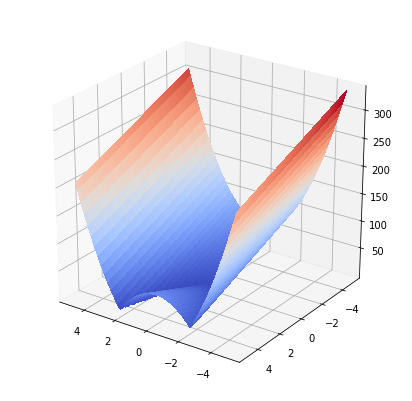

In [5]:
from mpl_toolkits import mplot3d
from matplotlib import cm

plt.rcParams['figure.figsize'] = [7, 7]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(25, 125)

# Make data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = np.sqrt(100*(Y - X**2)**2) + (1 - X)**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Defining helper functions
For answering the next parts of the first question, I defined some functions that help with finding the `phi` function and checking `alpha`s under `wolfe` and `goldstein` conditions.

In [6]:
from algorithms.linalg_utils import *
from algorithms.line_search import line_search_utils as lsu


def phi_for_nth_iteration_quasi_newton(f, g, hf, x0, n, c, r, alpha0, backtrack_selection=True, repair_hessian=True,
                                       use_identity_h0=False, hessian_method=qn.HessianMethod.HESSIAN, eps=1e-5):
    
    iterations = 0
    x = x0

    if use_identity_h0:
        h = np.identity(x.shape[0])
    else:
        h = inverse_matrix(hf(x))
    if repair_hessian:
        h = repair_psd(h)
        
    while True:

        iterations += 1
        p = -np.atleast_1d(np.matmul(h, g(x)))

        if backtrack_selection:
            alpha = lsu.backtrack_step_length(f, g, x, alpha0, p, r, c)
        else:
            alpha = lsu.interpolation_step_length(f, g, x, alpha0, p, c)
        
        if iterations == n:
            return x, p, alpha

        next_x = x + alpha*p
        if np.allclose(f(x), f(next_x), eps):
            if n == -1:
                return x, p, alpha
            break

        if hessian_method == qn.HessianMethod.HESSIAN:
            h = inverse_matrix(hf(next_x))
        elif hessian_method == qn.HessianMethod.BFGS:
            h = qn.approximate_hessian_bfgs(g, x, next_x, h)
        else:
            h = qn.approximate_hessian_sr1(g, x, next_x, h)
        if repair_hessian:
            h = repair_psd(h)

        x = next_x


def phi_for_nth_iteration_steepest_descent(f, g, x0, n, c, r, alpha0, backtrack_selection=True, eps=1e-5):

    x = x0
    iterations = 0
    initial_alpha = alpha0

    while True:

        p = -g(x)
        if backtrack_selection:
            alpha = lsu.backtrack_step_length(f, g, x, initial_alpha, p, r, c)
        else:
            alpha = lsu.interpolation_step_length(f, g, x, initial_alpha, p, c)

        next_x = x + alpha * p
        initial_alpha = sd.update_initial_alpha(f, g, x, next_x)
        
        iterations += 1
        if iterations == n:
            return x, p, alpha
        
        if np.allclose(f(x), f(next_x), eps):
            if n == -1:
                return x, p, alpha
            break

        x = next_x

In [7]:
def find_alpha_for_wolfe_conditions(f, g, x, p, c1, c2, alphas):
    result = []
    for alpha in alphas:
        if lsu.step_satisfies_wolfe_conditions(f, g, x, alpha, p, c1, c2):
            result.append(alpha)
    return result


def find_alpha_for_goldstein_conditions(f, g, x, p, c, alphas):
    result = []
    for alpha in alphas:
        if lsu.step_satisfies_goldstein_condition(f, g, x, alpha, p, c):
            result.append(alpha)
    return result

## Drawing `phi(alpha)` function and checking conditions on it
In this part, I've drawn the `phi(alpha)` function for the first and last iteration of the steepest descent algorithms for each starting point defined in the project description (`x1s` array contains them).
After drawing the `phi(alpha)` function, I mark the `alpha`s that satisfy wolfe or goldstein conditions using other colors and also draw the selected `alpha` as a red point on the plot.
The first six figures correspond to the `phi(alpha)`s for the first(left) and last(right) iteration of the selected algorithm on each starting point (each row).
### Stepest descent with backtrack step length selection

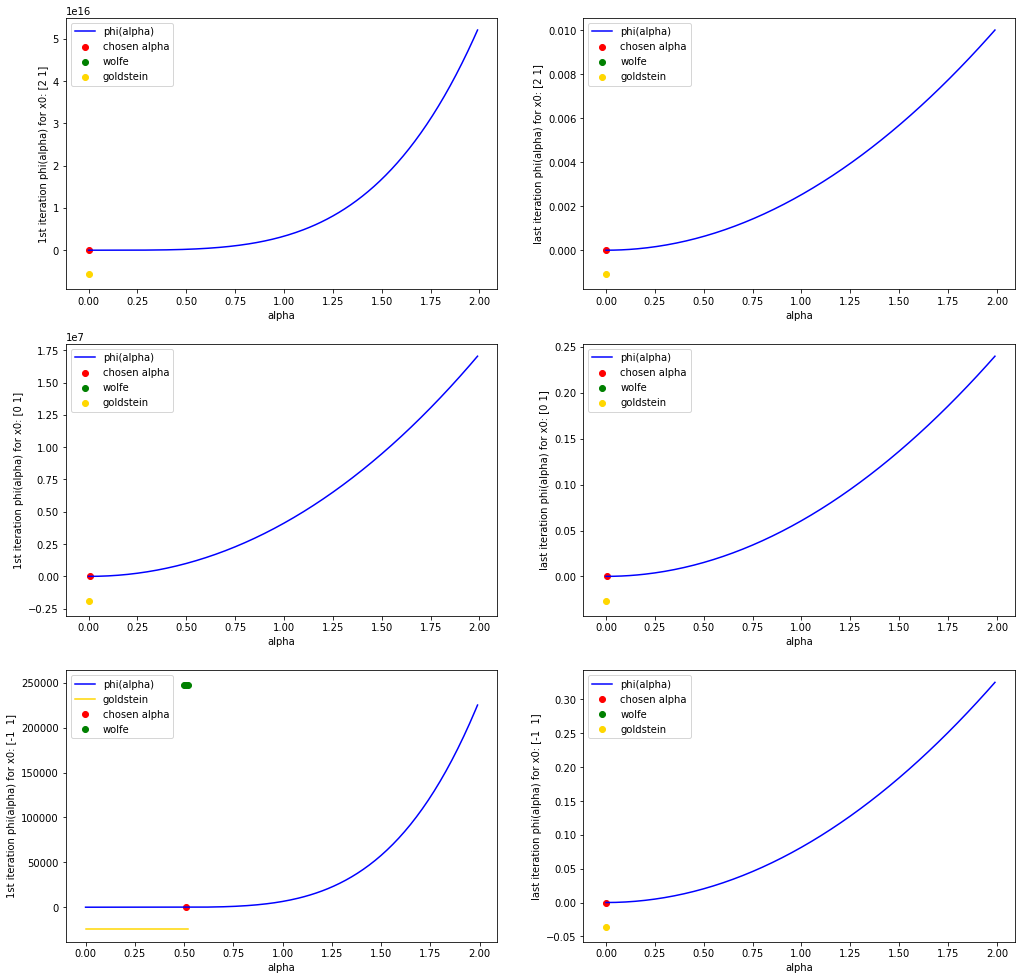

In [8]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_steepest_descent(f1, g1, x1s[i], 1, wc1, .95, 1.1, backtrack_selection=True) for i in range(len(x1s))]
phi_lasts = [phi_for_nth_iteration_steepest_descent(f1, g1, x1s[i], -1, wc1, .95, 1.1, backtrack_selection=True) for i in range(len(x1s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()



### Stepest descent with cubic interpolation step length selection

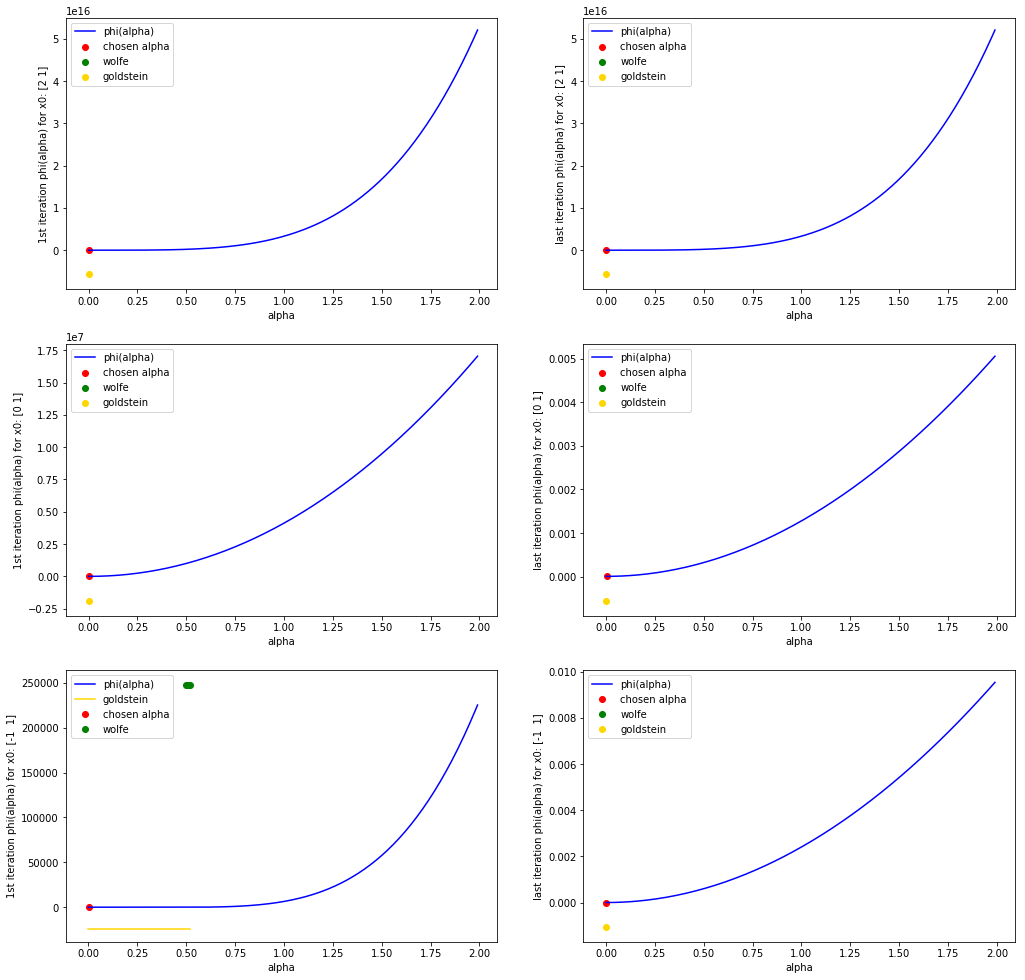

In [9]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_steepest_descent(f1, g1, x1s[i], 1, wc1, .9, 1.1, backtrack_selection=False) for i in range(len(x1s))]
phi_lasts = [phi_for_nth_iteration_steepest_descent(f1, g1, x1s[i], -1, wc1, .9, 1.1, backtrack_selection=False) for i in range(len(x1s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()



### Quasi-Newton with backtrack step length selection and BFGS hessian approximation

In [4]:
wc1 = .001
wc2 = .0005
gc = .25

phi_firsts = [phi_for_nth_iteration_quasi_newton(f1, g1, h1, x1s[i], 1, wc1, .9, 1.1, 
                                                 hessian_method=qn.HessianMethod.BFGS, backtrack_selection=True) for i in range(len(x1s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f1, g1, h1, x1s[i], -1, wc1, .9, 1.1, 
                                                hessian_method=qn.HessianMethod.BFGS, backtrack_selection=True) for i in range(len(x1s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


NameError: name 'x1s' is not defined

### Quasi-Newton with cubic interpolation step length selection and BFGS hessian approximation

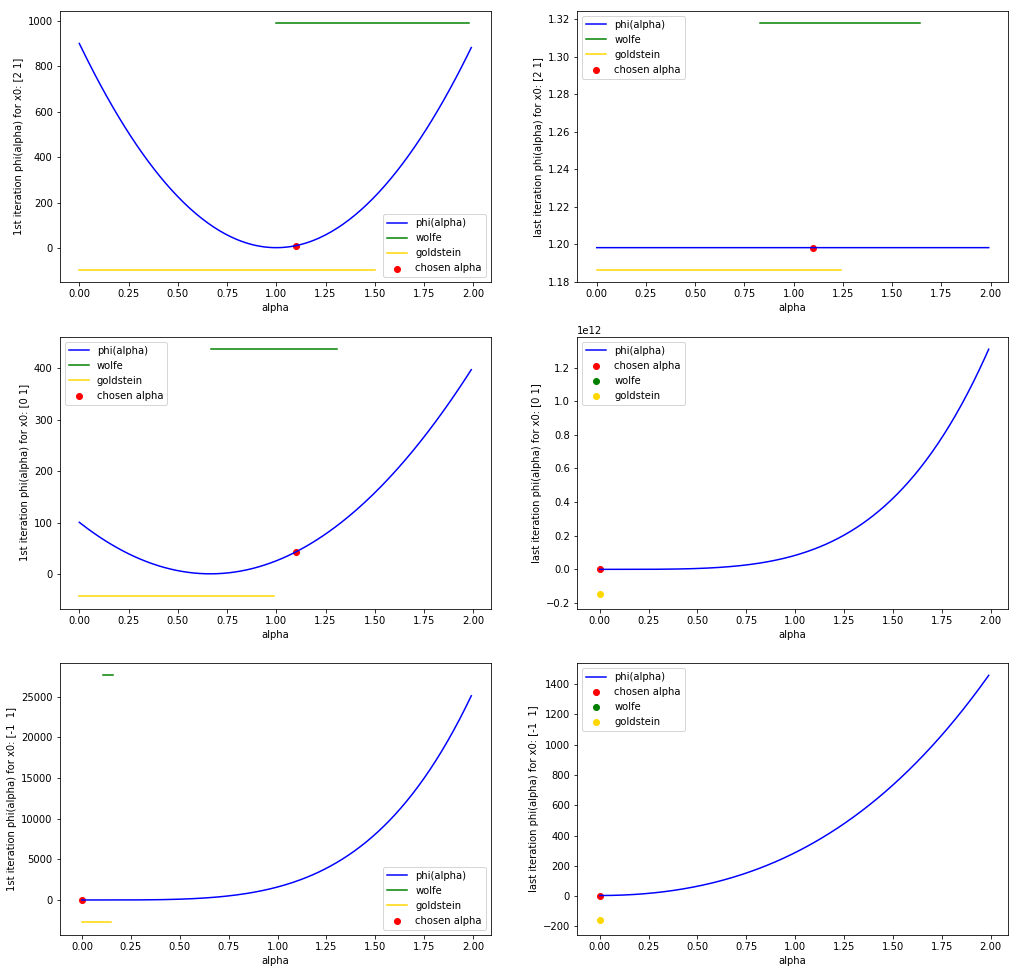

In [11]:
wc1 = .01
wc2 = .005
gc = .25

phi_firsts = [phi_for_nth_iteration_quasi_newton(f1, g1, h1, x1s[i], 1, wc1, .9, 1.1, 
                                                 hessian_method=qn.HessianMethod.BFGS, backtrack_selection=False) for i in range(len(x1s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f1, g1, h1, x1s[i], -1, wc1, .9, 1.1, 
                                                hessian_method=qn.HessianMethod.BFGS, backtrack_selection=False) for i in range(len(x1s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()



### Quasi-Newton with backtrack step length selection and exact hessian

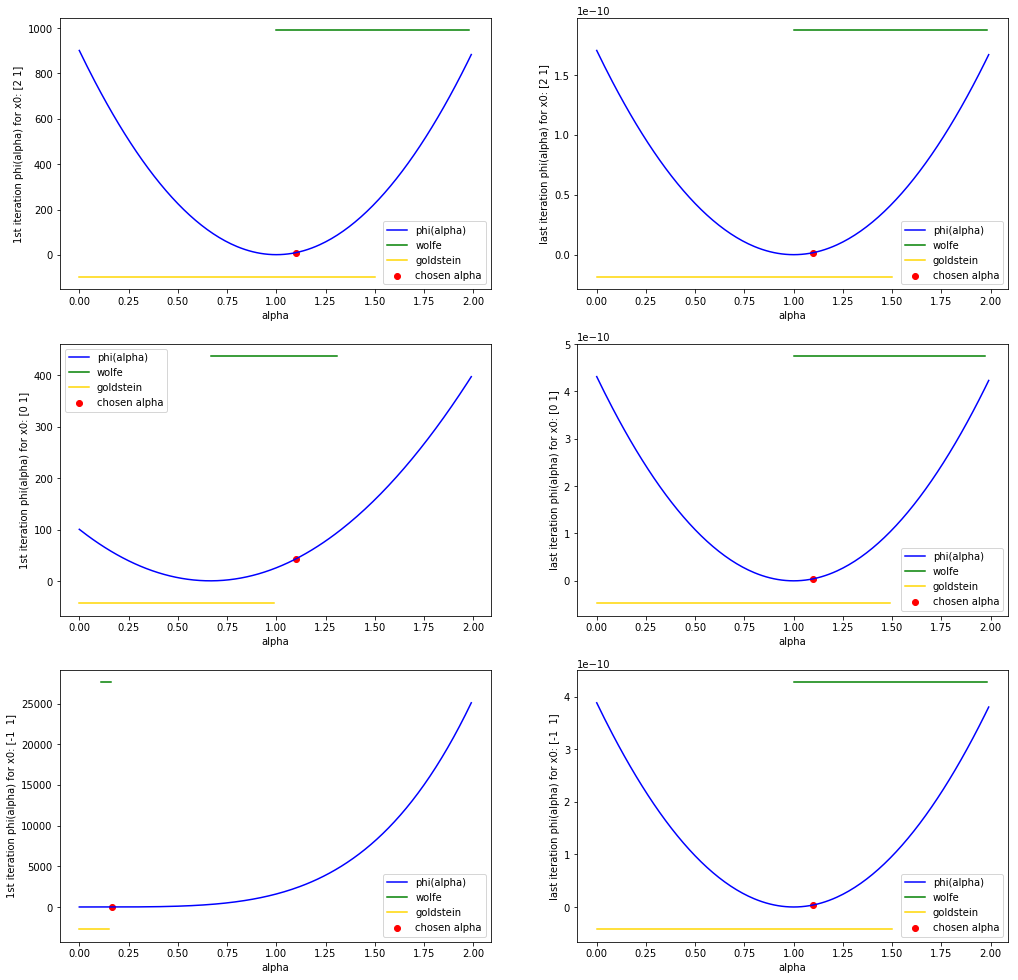

In [12]:
wc1 = .01
wc2 = .005
gc = .25

phi_firsts = [phi_for_nth_iteration_quasi_newton(f1, g1, h1, x1s[i], 1, wc1, .9, 1.1, 
                                                 hessian_method=qn.HessianMethod.HESSIAN, backtrack_selection=True) for i in range(len(x1s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f1, g1, h1, x1s[i], -1, wc1, .9, 1.1, 
                                                hessian_method=qn.HessianMethod.HESSIAN, backtrack_selection=True) for i in range(len(x1s))]


x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


### Quasi-Newton with cubic interpolation step length selection and exact hessian

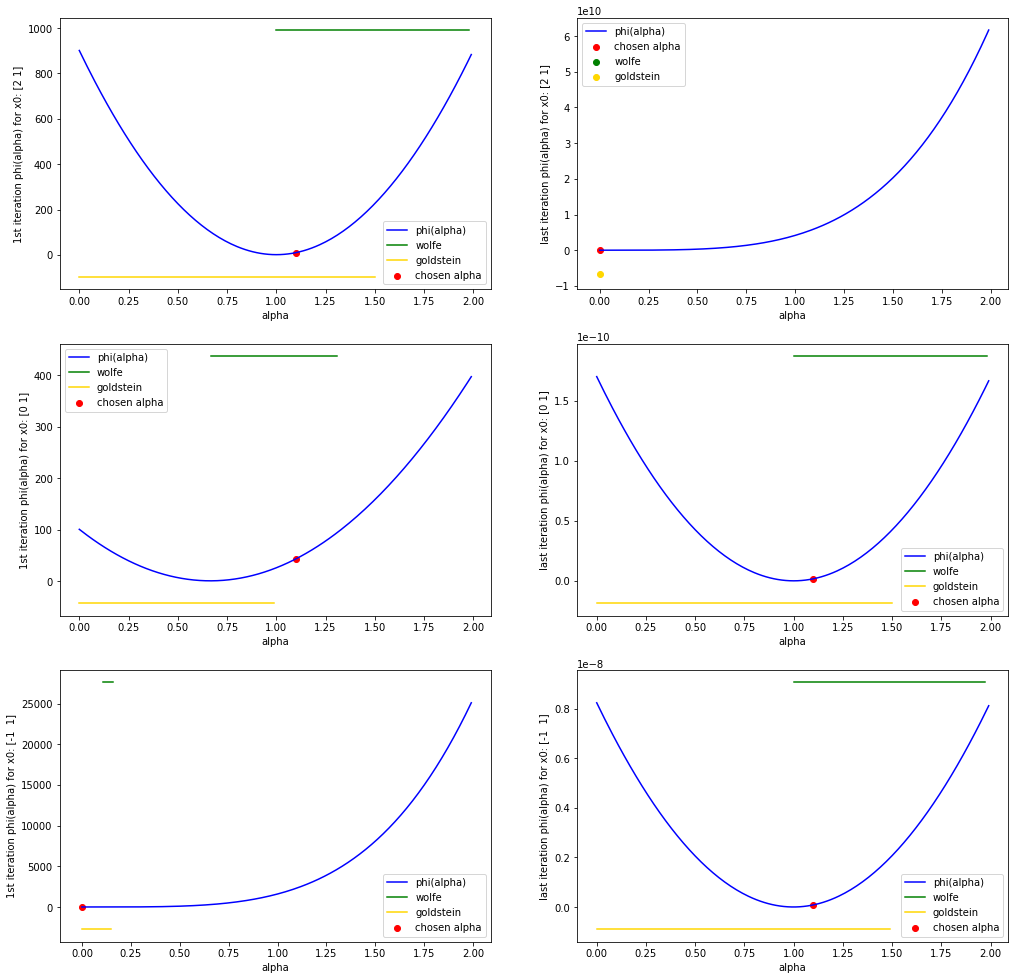

In [13]:
wc1 = .01
wc2 = .005
gc = .25

phi_firsts = [phi_for_nth_iteration_quasi_newton(f1, g1, h1, x1s[i], 1, wc1, .9, 1.1, 
                                                 hessian_method=qn.HessianMethod.HESSIAN, backtrack_selection=False) for i in range(len(x1s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f1, g1, h1, x1s[i], -1, wc1, .9, 1.1, 
                                                hessian_method=qn.HessianMethod.HESSIAN, backtrack_selection=False) for i in range(len(x1s))]


x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f1(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f1, g1, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f1, g1, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f1(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()



# Todo: SR1 Problem with NaN
# Todo: Analyze results

## Defining helper functions
For answering the next parts of the first question, I defined some other functions that help with analyzing the progress of the Quasi-Newton and steepest descent algorithms.

In [36]:
def get_progress_quasi_newton(f, g, hf, x0, c, r, alpha0, decreasing_mul=1, backtrack_selection=True, repair_hessian=True,
                              use_identity_h0=False, hessian_method=qn.HessianMethod.HESSIAN, eps=1e-5):
    
    x = x0
    differences = []
    decreasing_ps = []

    if use_identity_h0:
        h = np.identity(x.shape[0])
    else:
        h = inverse_matrix(hf(x))
    if repair_hessian:
        h = repair_psd(h)
        
    while True:

        p = -np.atleast_1d(np.matmul(h, g(x)))

        if backtrack_selection:
            alpha = lsu.backtrack_step_length(f, g, x, alpha0, p, r, c)
        else:
            alpha = lsu.interpolation_step_length(f, g, x, alpha0, p, c)
        
        next_x = x + alpha*p
        differences.append(np.abs(f(next_x) - f(x)))
        if f(x + eps*p) < f(x):
            decreasing_ps.append(1 * decreasing_mul)
        else:
            decreasing_ps.append(-1 * decreasing_mul)
        
        if np.allclose(f(x), f(next_x), eps):
            return decreasing_ps, differences

        if hessian_method == qn.HessianMethod.HESSIAN:
            h = inverse_matrix(hf(next_x))
        elif hessian_method == qn.HessianMethod.BFGS:
            h = qn.approximate_hessian_bfgs(g, x, next_x, h)
        else:
            h = qn.approximate_hessian_sr1(g, x, next_x, h)
        if repair_hessian:
            h = repair_psd(h)

        x = next_x


def get_progress_steepest_descent(f, g, x0, c, r, alpha0, decreasing_mul=1, backtrack_selection=True, eps=1e-5):

    x = x0
    initial_alpha = alpha0
    differences = []
    decreasing_ps = []

    while True:

        p = -g(x)
        if backtrack_selection:
            alpha = lsu.backtrack_step_length(f, g, x, initial_alpha, p, r, c)
        else:
            alpha = lsu.interpolation_step_length(f, g, x, initial_alpha, p, c)

        next_x = x + alpha * p
        initial_alpha = sd.update_initial_alpha(f, g, x, next_x)
        
        differences.append(np.abs(f(next_x) - f(x)))
        if f(x + eps*p) < f(x):
            decreasing_ps.append(1 * decreasing_mul)
        else:
            decreasing_ps.append(-1 * decreasing_mul)
        
        if np.allclose(f(x), f(next_x), eps):
            return decreasing_ps, differences

        x = next_x

## Analyzing the progress of steepest descent algorithm
Here I used backtrack and cubic interpolation step length selection methods in steepest descent algorithm to check if the `pk` steps are decreasing(`1 * decreasing_mul`) or not (`-1 * decreasing_mul`) and also plotting the difference of progresses in each step based on the function value of each `xk` and its difference with the previous `x`.
Each row corresponds to a specific starting point, and in each row, the left column corresponds to checking if the `pk` in the kth step is decreasing in each iteration and the right column corresponds to the function difference in each iteration.
### Steepest descent

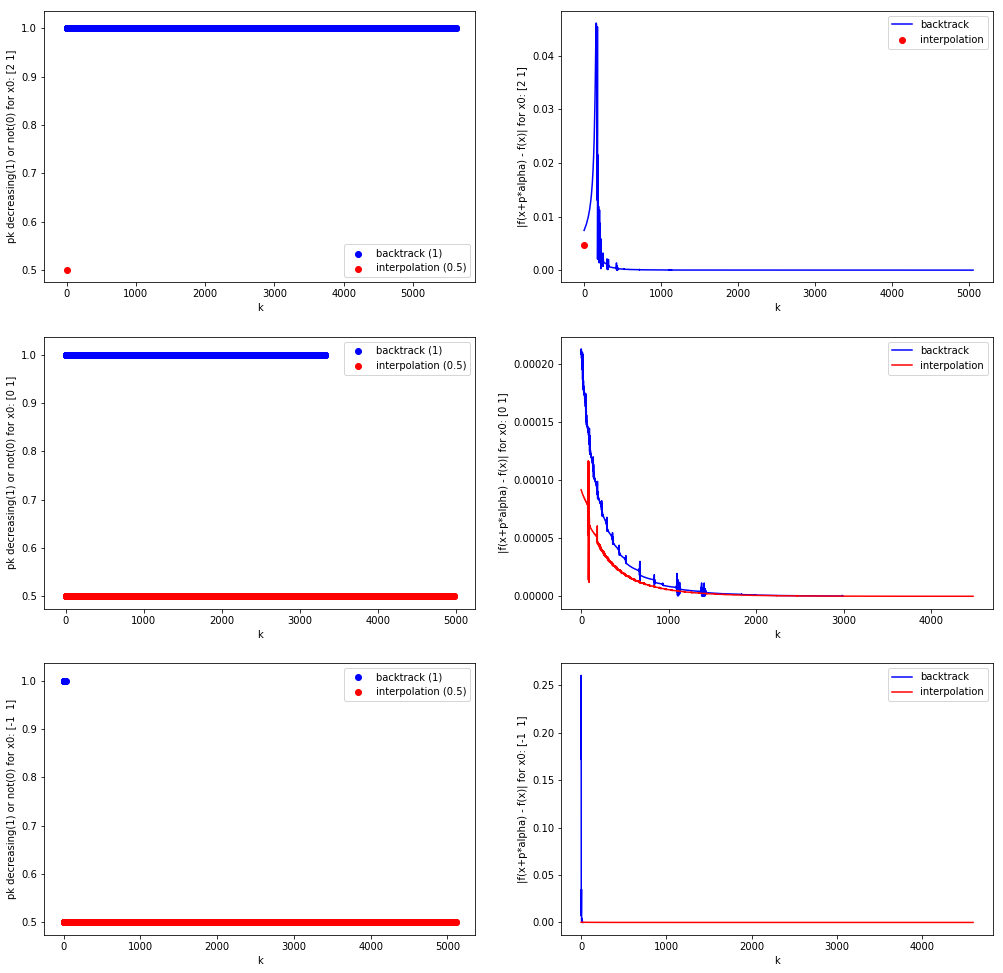

In [39]:
wc1 = .001
wc2 = .0005
gc = .05

progress_data1 = [get_progress_steepest_descent(f1, g1, x1s[i], wc1, .95, 1.1, backtrack_selection=True) for i in range(len(x1s))]
progress_data2 = [get_progress_steepest_descent(f1, g1, x1s[i], wc1, .95, 1.1, decreasing_mul=.5, backtrack_selection=False) for i in range(len(x1s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    ps1 = progress_data1[i][0]
    differences1 = progress_data1[i][1]
    differences1 = differences1[len(differences1)/10:]
    xp1 = [j for j in range(len(ps1))]
    xd1 = [j for j in range(len(differences1))]
    
    ps2 = progress_data2[i][0]
    differences2 = progress_data2[i][1]
    differences2 = differences2[len(differences2)/10:]
    xp2 = [j for j in range(len(ps2))]
    xd2 = [j for j in range(len(differences2))]
    
    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.scatter(xp1, ps1, color='blue', label='backtrack (1)')
    plt.scatter(xp2, ps2, color='red', label='interpolation (0.5)')
    plt.xlabel('k')
    plt.ylabel('pk decreasing(1) or not(0) for x0: %s' % x1s[i])
    plt.legend()
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    if len(xd1) < 5:
        plt.scatter(xd1, differences1, color='blue', label='backtrack')
    else:
        plt.plot(xd1, differences1, color='blue', label='backtrack')
    if len(xd2) < 5:
        plt.scatter(xd2, differences2, color='red', label='interpolation')
    else:
        plt.plot(xd2, differences2, color='red', label='interpolation')
    plt.xlabel('k')
    plt.ylabel('|f(x+p*alpha) - f(x)| for x0: %s' % x1s[i])
    plt.legend()


### Quasi-Newton with BFGS hessian aproximation

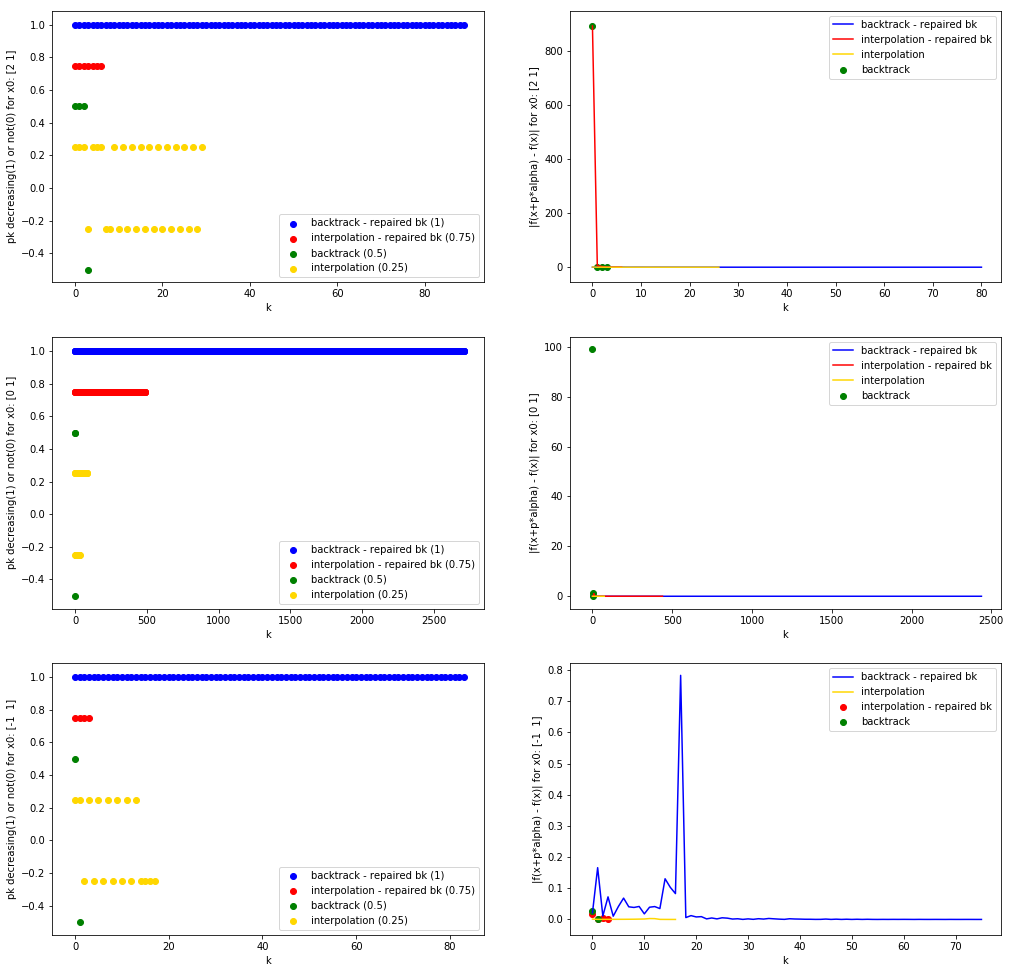

In [43]:
wc1 = .001
wc2 = .0005
gc = .05

progress_data1 = [get_progress_quasi_newton(f1, g1, h1, x1s[i], wc1, .95, 1.1, decreasing_mul=1,
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x1s))]
progress_data2 = [get_progress_quasi_newton(f1, g1, h1, x1s[i], wc1, .95, 1.1, decreasing_mul=.75,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x1s))]
progress_data3 = [get_progress_quasi_newton(f1, g1, h1, x1s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.5, 
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x1s))]
progress_data4 = [get_progress_quasi_newton(f1, g1, h1, x1s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.25,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x1s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    ps1 = progress_data1[i][0]
    differences1 = progress_data1[i][1]
    differences1 = differences1[len(differences1)/10:]
    xp1 = [j for j in range(len(ps1))]
    xd1 = [j for j in range(len(differences1))]
    
    ps2 = progress_data2[i][0]
    differences2 = progress_data2[i][1]
    differences2 = differences2[len(differences2)/10:]
    xp2 = [j for j in range(len(ps2))]
    xd2 = [j for j in range(len(differences2))]
    
    ps3 = progress_data3[i][0]
    differences3 = progress_data3[i][1]
    differences3 = differences3[len(differences3)/10:]
    xp3 = [j for j in range(len(ps3))]
    xd3 = [j for j in range(len(differences3))]
    
    ps4 = progress_data4[i][0]
    differences4 = progress_data4[i][1]
    differences4 = differences4[len(differences4)/10:]
    xp4 = [j for j in range(len(ps4))]
    xd4 = [j for j in range(len(differences4))]
    
    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.scatter(xp1, ps1, color='blue', label='backtrack - repaired bk (1)')
    plt.scatter(xp2, ps2, color='red', label='interpolation - repaired bk (0.75)')
    plt.scatter(xp3, ps3, color='green', label='backtrack (0.5)')
    plt.scatter(xp4, ps4, color='gold', label='interpolation (0.25)')
    plt.xlabel('k')
    plt.ylabel('pk decreasing(1) or not(0) for x0: %s' % x1s[i])
    plt.legend()
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    if len(xd1) < 5:
        plt.scatter(xd1, differences1, color='blue', label='backtrack - repaired bk')
    else:
        plt.plot(xd1, differences1, color='blue', label='backtrack - repaired bk')
    if len(xd2) < 5:
        plt.scatter(xd2, differences2, color='red', label='interpolation - repaired bk')
    else:
        plt.plot(xd2, differences2, color='red', label='interpolation - repaired bk')
    if len(xd3) < 5:
        plt.scatter(xd3, differences3, color='green', label='backtrack')
    else:
        plt.plot(xd3, differences3, color='green', label='backtrack')
    if len(xd4) < 5:
        plt.scatter(xd4, differences4, color='gold', label='interpolation')
    else:
        plt.plot(xd4, differences4, color='gold', label='interpolation')
    plt.xlabel('k')
    plt.ylabel('|f(x+p*alpha) - f(x)| for x0: %s' % x1s[i])
    plt.legend()


### Quasi-Newton with exact hessian

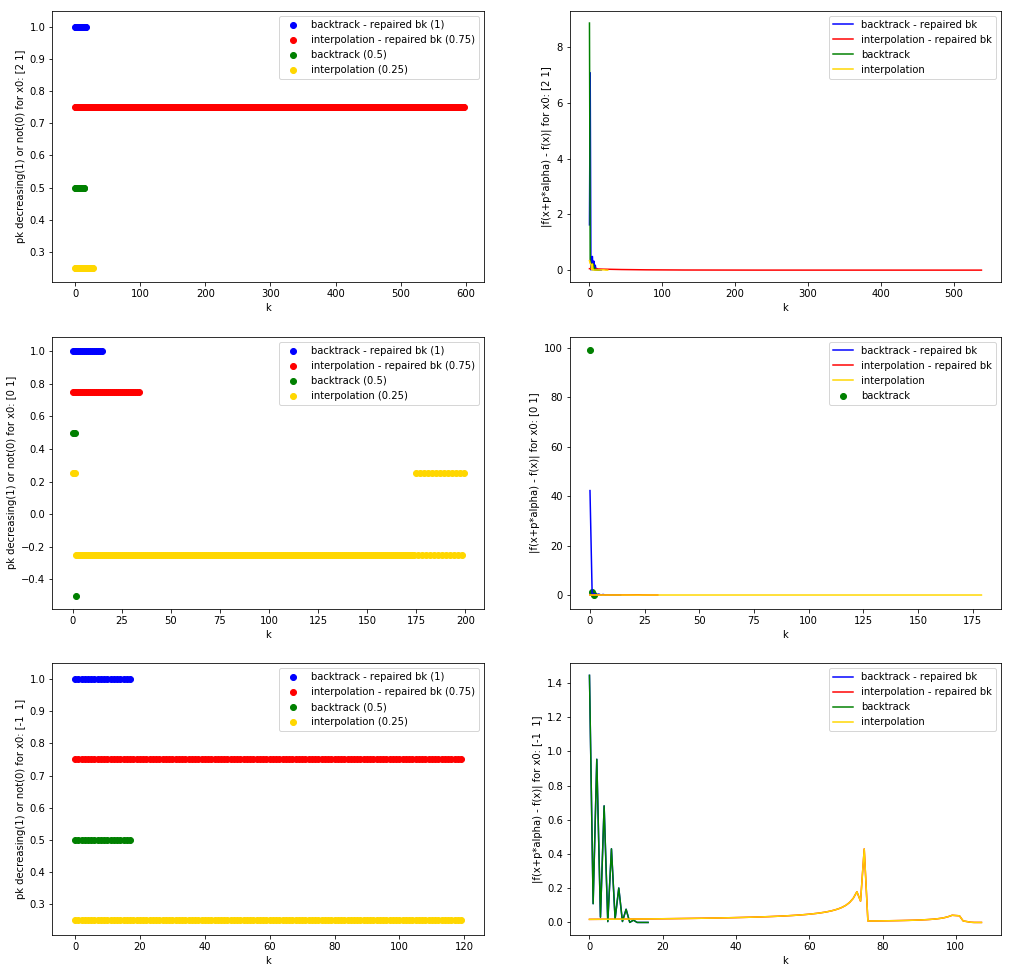

In [49]:
wc1 = .001
wc2 = .0005
gc = .05

progress_data1 = [get_progress_quasi_newton(f1, g1, h1, x1s[i], wc1, .95, 1.1, decreasing_mul=1,
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x1s))]
progress_data2 = [get_progress_quasi_newton(f1, g1, h1, x1s[i], wc1, .95, 1.1, decreasing_mul=.75,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x1s))]
progress_data3 = [get_progress_quasi_newton(f1, g1, h1, x1s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.5, 
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x1s))]
progress_data4 = [get_progress_quasi_newton(f1, g1, h1, x1s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.25,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x1s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x1s)):
    
    ps1 = progress_data1[i][0]
    differences1 = progress_data1[i][1]
    differences1 = differences1[len(differences1)/10:]
    xp1 = [j for j in range(len(ps1))]
    xd1 = [j for j in range(len(differences1))]
    
    ps2 = progress_data2[i][0]
    differences2 = progress_data2[i][1]
    differences2 = differences2[len(differences2)/10:]
    xp2 = [j for j in range(len(ps2))]
    xd2 = [j for j in range(len(differences2))]
    
    ps3 = progress_data3[i][0]
    differences3 = progress_data3[i][1]
    differences3 = differences3[len(differences3)/10:]
    xp3 = [j for j in range(len(ps3))]
    xd3 = [j for j in range(len(differences3))]
    
    ps4 = progress_data4[i][0]
    differences4 = progress_data4[i][1]
    differences4 = differences4[len(differences4)/10:]
    xp4 = [j for j in range(len(ps4))]
    xd4 = [j for j in range(len(differences4))]
    
    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.scatter(xp1, ps1, color='blue', label='backtrack - repaired bk (1)')
    plt.scatter(xp2, ps2, color='red', label='interpolation - repaired bk (0.75)')
    plt.scatter(xp3, ps3, color='green', label='backtrack (0.5)')
    plt.scatter(xp4, ps4, color='gold', label='interpolation (0.25)')
    plt.xlabel('k')
    plt.ylabel('pk decreasing(1) or not(0) for x0: %s' % x1s[i])
    plt.legend()
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    if len(xd1) < 5:
        plt.scatter(xd1, differences1, color='blue', label='backtrack - repaired bk')
    else:
        plt.plot(xd1, differences1, color='blue', label='backtrack - repaired bk')
    if len(xd2) < 5:
        plt.scatter(xd2, differences2, color='red', label='interpolation - repaired bk')
    else:
        plt.plot(xd2, differences2, color='red', label='interpolation - repaired bk')
    if len(xd3) < 5:
        plt.scatter(xd3, differences3, color='green', label='backtrack')
    else:
        plt.plot(xd3, differences3, color='green', label='backtrack')
    if len(xd4) < 5:
        plt.scatter(xd4, differences4, color='gold', label='interpolation')
    else:
        plt.plot(xd4, differences4, color='gold', label='interpolation')
    plt.xlabel('k')
    plt.ylabel('|f(x+p*alpha) - f(x)| for x0: %s' % x1s[i])
    plt.legend()


# Part Two: The second function (f2)
We first draw the function to assess its characters and check if it's convex or not. As can be seen in the plot below, the function is **not convex**.

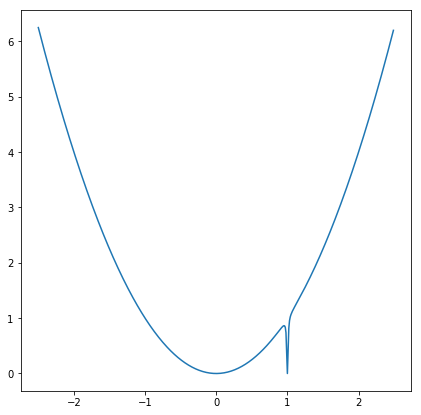

In [53]:
plt.rcParams['figure.figsize'] = [7, 7]

# Make data.
X = np.arange(-2.5, 2.5, 0.01)
Y = X**2 + np.exp(-.0001 / (X-1)**2) - 1

# Plot the surface.
plt.plot(X, Y)

## Drawing `phi(alpha)` function and checking conditions on it
In this part, I've drawn the `phi(alpha)` function for the first and last iteration of the steepest descent algorithms for each starting point defined in the project description (`x1s` array contains them).
After drawing the `phi(alpha)` function, I mark the `alpha`s that satisfy wolfe or goldstein conditions using other colors and also draw the selected `alpha` as a red point on the plot.
The first six figures correspond to the `phi(alpha)`s for the first(left) and last(right) iteration of the selected algorithm on each starting point (each row).
### Stepest descent with backtrack step length selection

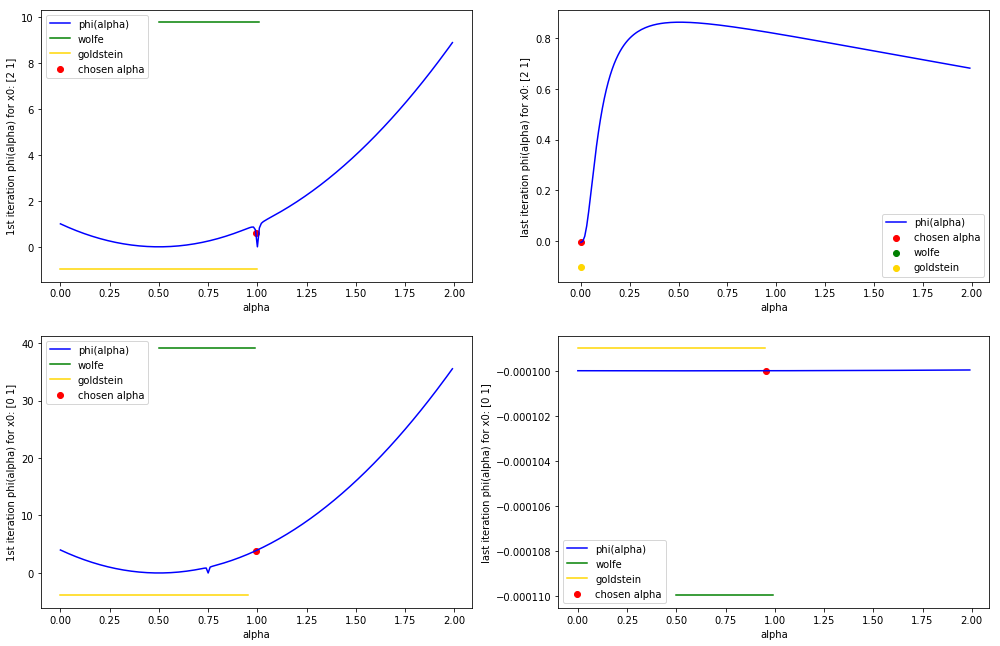

In [59]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_steepest_descent(f2, g2, x2s[i], 1, wc1, .95, 1.1, backtrack_selection=True) for i in range(len(x2s))]
phi_lasts = [phi_for_nth_iteration_steepest_descent(f2, g2, x2s[i], -1, wc1, .95, 1.1, backtrack_selection=True) for i in range(len(x2s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


### Stepest descent with cubic interpolation step length selection

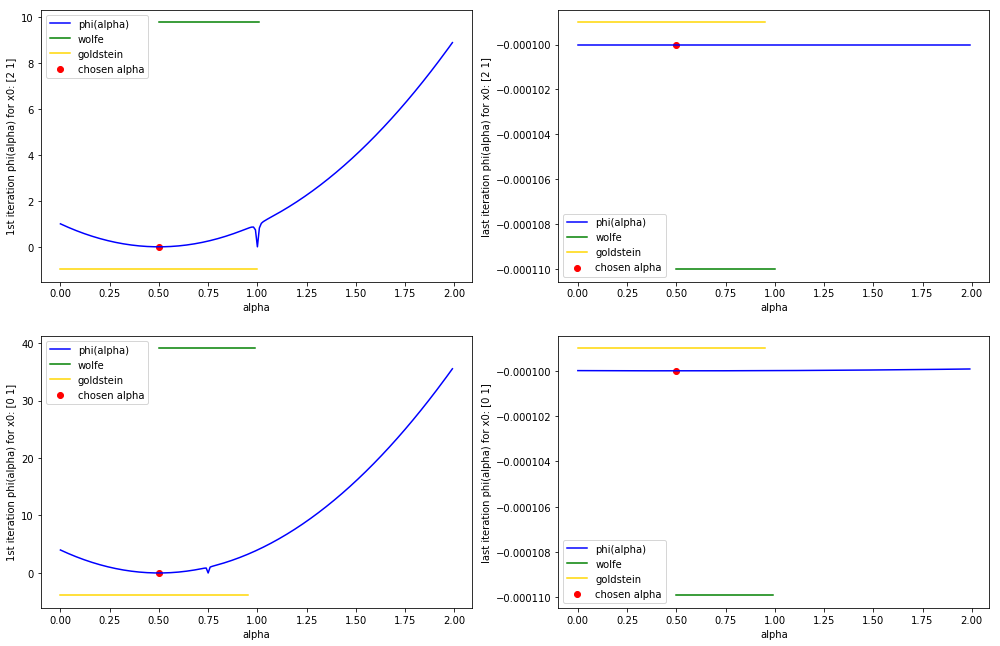

In [60]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_steepest_descent(f2, g2, x2s[i], 1, wc1, .95, 1.1, backtrack_selection=False) for i in range(len(x2s))]
phi_lasts = [phi_for_nth_iteration_steepest_descent(f2, g2, x2s[i], -1, wc1, .95, 1.1, backtrack_selection=False) for i in range(len(x2s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


### Quasi-Newton with backtrack step length selection and BFGS hessian approximation

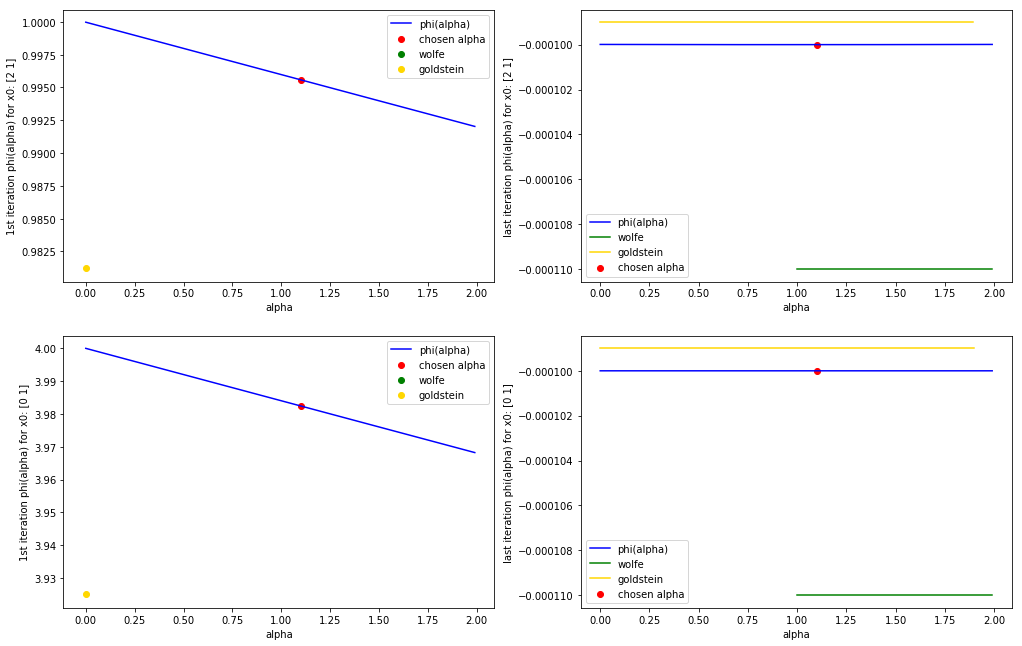

In [61]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], 1, wc1, .95, 1.1, 
                                                 backtrack_selection=True, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x2s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], -1, wc1, .95, 1.1, 
                                                backtrack_selection=True, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x2s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


### Quasi-Newton with cubic interpolation step length selection and BFGS hessian approximation

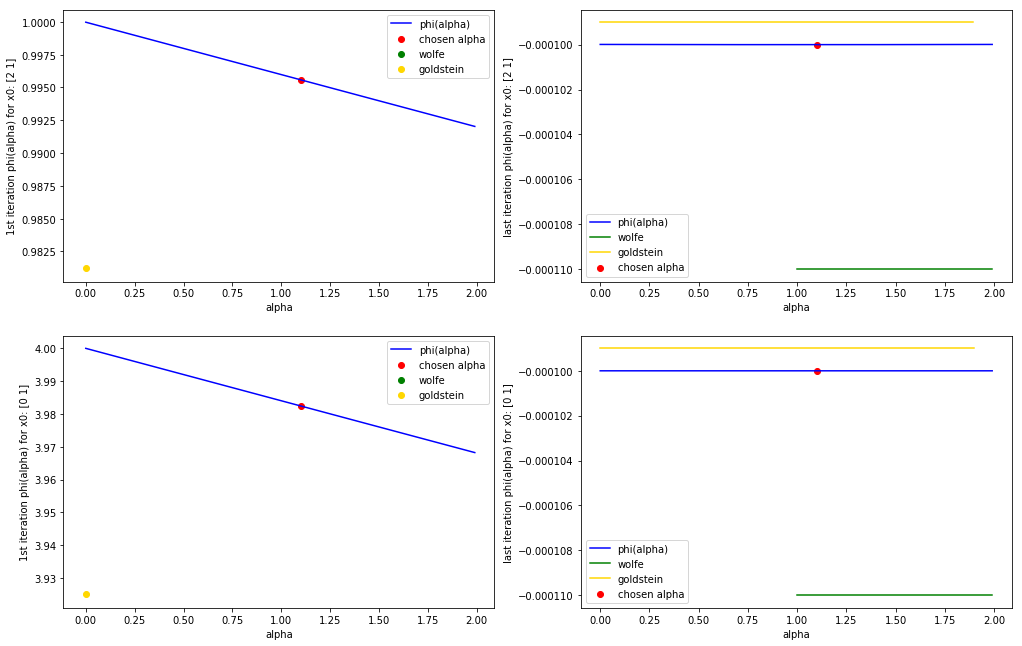

In [62]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], 1, wc1, .95, 1.1, 
                                                 backtrack_selection=False, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x2s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], -1, wc1, .95, 1.1, 
                                                backtrack_selection=False, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x2s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


### Quasi-Newton with backtrack step length selection and exact hessian

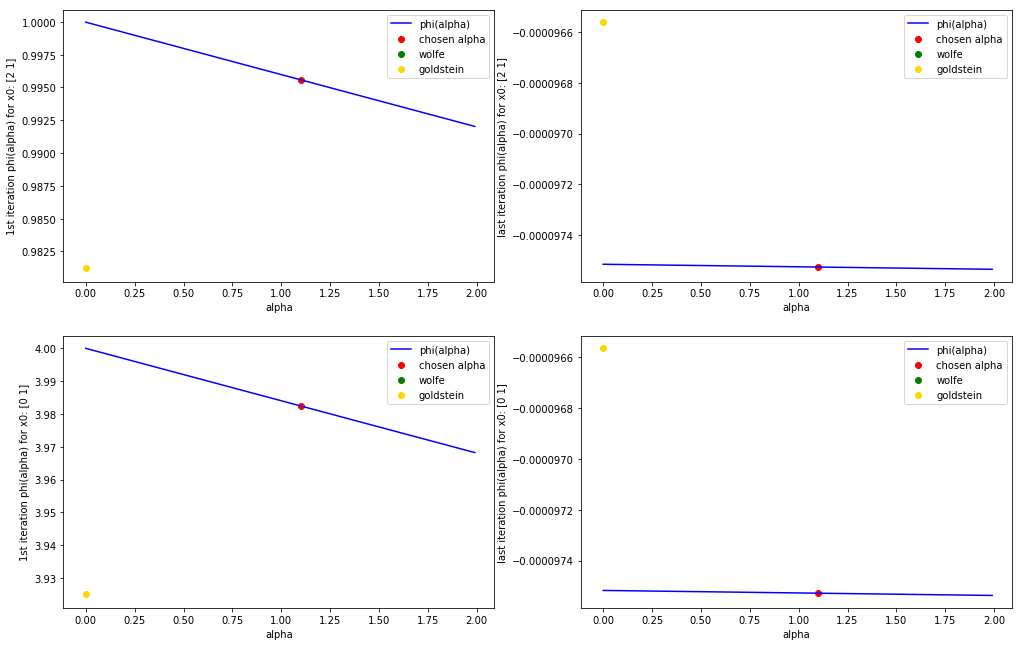

In [63]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], 1, wc1, .95, 1.1, 
                                                 backtrack_selection=True, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x2s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], -1, wc1, .95, 1.1, 
                                                backtrack_selection=True, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x2s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


### Quasi-Newton with cubic interpolation step length selection and exact hessian

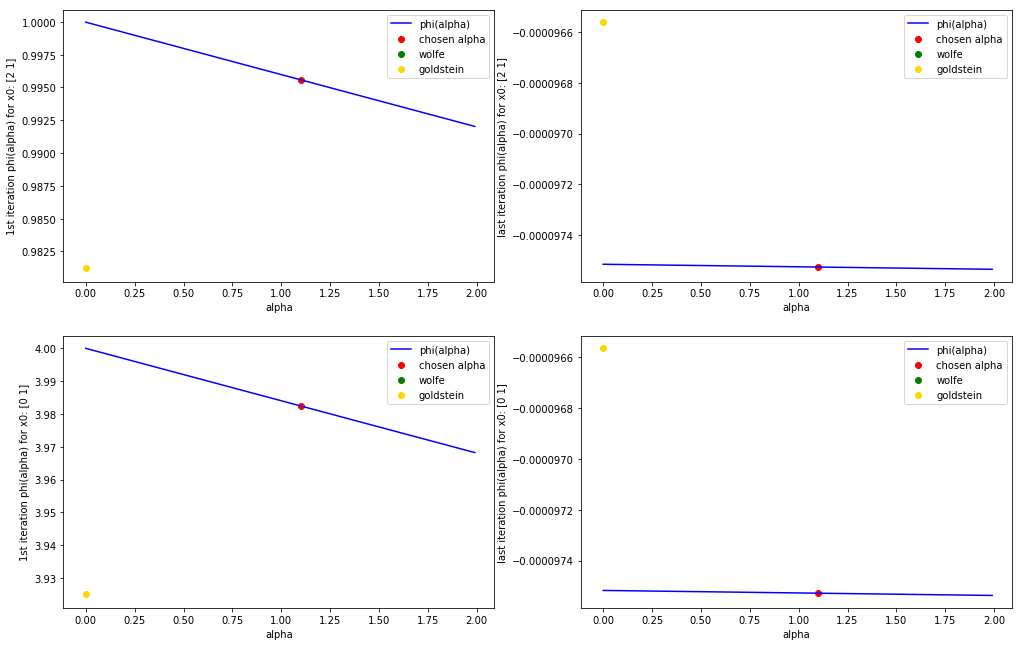

In [65]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], 1, wc1, .95, 1.1, 
                                                 backtrack_selection=False, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x2s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], -1, wc1, .95, 1.1, 
                                                backtrack_selection=False, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x2s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


### Quasi-Newton with backtrack step length selection and SR1 hessian approximation

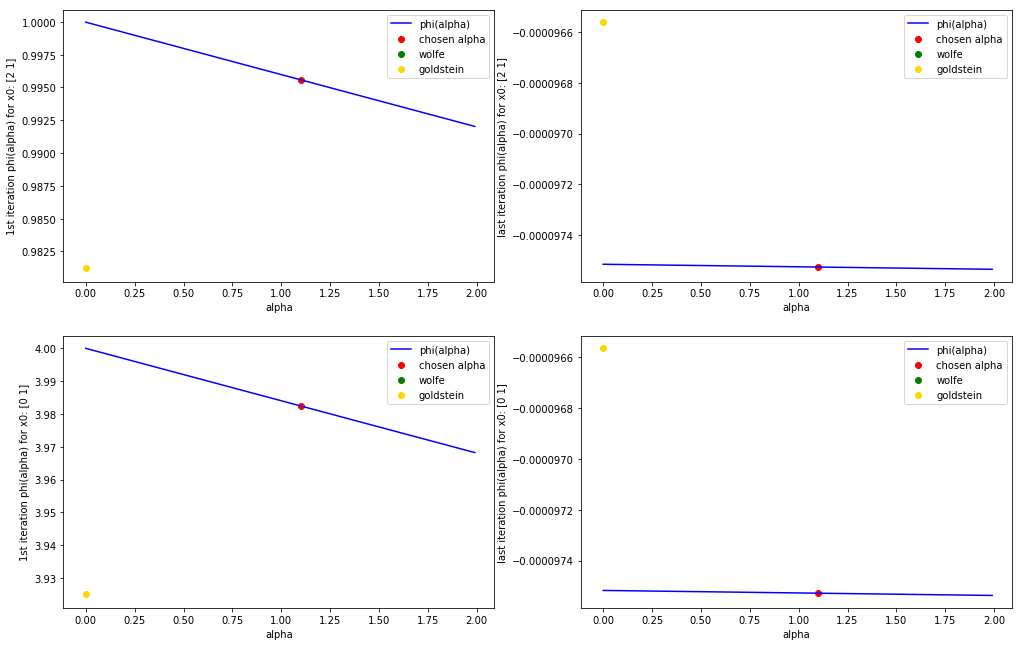

In [66]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], 1, wc1, .95, 1.1, 
                                                 backtrack_selection=True, hessian_method=qn.HessianMethod.SR1) for i in range(len(x2s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], -1, wc1, .95, 1.1, 
                                                backtrack_selection=True, hessian_method=qn.HessianMethod.SR1) for i in range(len(x2s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


### Quasi-Newton with cubic interpolation step length selection and SR1 hessian approximation

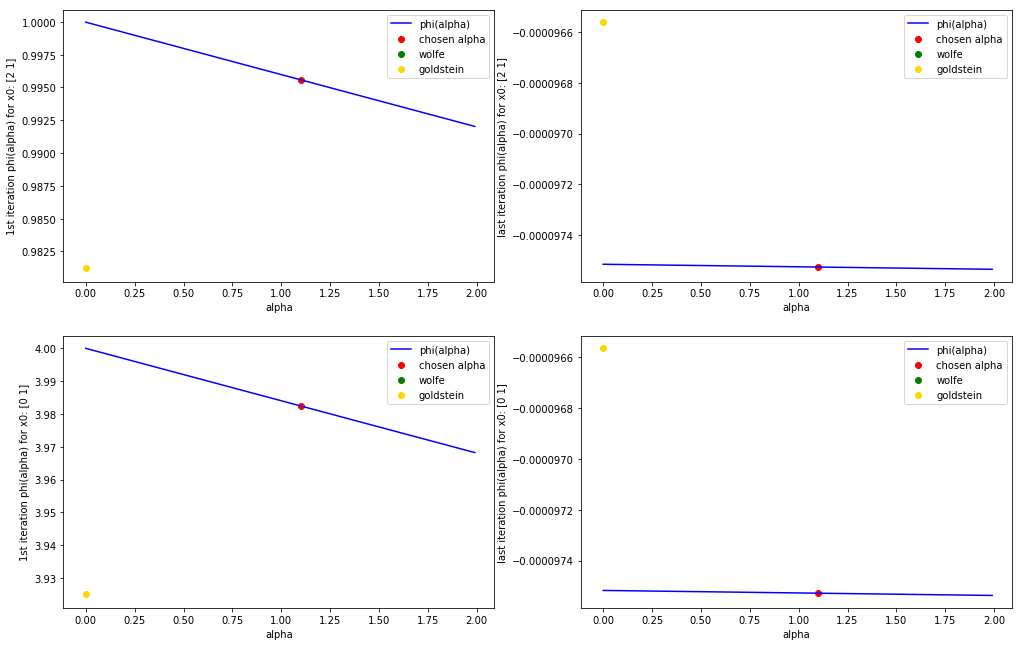

In [68]:
wc1 = .001
wc2 = .0005
gc = .05

phi_firsts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], 1, wc1, .95, 1.1, 
                                                 backtrack_selection=False, hessian_method=qn.HessianMethod.SR1) for i in range(len(x2s))]
phi_lasts = [phi_for_nth_iteration_quasi_newton(f2, g2, h2, x2s[i], -1, wc1, .95, 1.1, 
                                                backtrack_selection=False, hessian_method=qn.HessianMethod.SR1) for i in range(len(x2s))]

x = np.arange(0, 2, .01)
plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    x0 = phi_firsts[i][0]
    p = phi_firsts[i][1]
    chosen_alpha = phi_firsts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)

    plt.subplot(len(x1s), 2, (i+1)*2-1)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.xlabel('alpha')
    plt.ylabel('1st iteration phi(alpha) for x0: %s' % x1s[i])
    plt.legend()
    
    x0 = phi_lasts[i][0]
    p = phi_lasts[i][1]
    chosen_alpha = phi_lasts[i][2]
    
    phis = [f2(x0 + alp*p) for alp in x]
    max_phi = max(phis)*1.1
    min_phi = min(phis) - (max_phi - min(phis))*.1

    alphas_for_wolfe = find_alpha_for_wolfe_conditions(f2, g2, x0, p, wc1, wc2, x)
    alphas_for_goldstein = find_alpha_for_goldstein_conditions(f2, g2, x0, p, gc, x)
    
    plt.subplot(len(x1s), 2, (i+1)*2)
    plt.plot(x, phis, color='blue', label='phi(alpha)')
    plt.scatter(chosen_alpha, f2(x0 + chosen_alpha*p), color='red', label='chosen alpha')
    if len(alphas_for_wolfe) < 5:
        plt.scatter(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    else:
        plt.plot(alphas_for_wolfe, [max_phi] * len(alphas_for_wolfe), color='green', label='wolfe')
    if len(alphas_for_goldstein) < 5:
        plt.scatter(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    else:
        plt.plot(alphas_for_goldstein, [min_phi] * len(alphas_for_goldstein), color='gold', label='goldstein')
    plt.ylabel('last iteration phi(alpha) for x0: %s' % x1s[i])
    plt.xlabel('alpha')
    plt.legend()


## Analyzing the progress of steepest descent algorithm
Here I used backtrack and cubic interpolation step length selection methods in steepest descent algorithm to check if the `pk` steps are decreasing(`1 * decreasing_mul`) or not (`-1 * decreasing_mul`) and also plotting the difference of progresses in each step based on the function value of each `xk` and its difference with the previous `x`. Each row corresponds to a specific starting point, and in each row, the left column corresponds to checking if the `pk` in the kth step is decreasing in each iteration and the right column corresponds to the function difference in each iteration.

### Steepest Descent

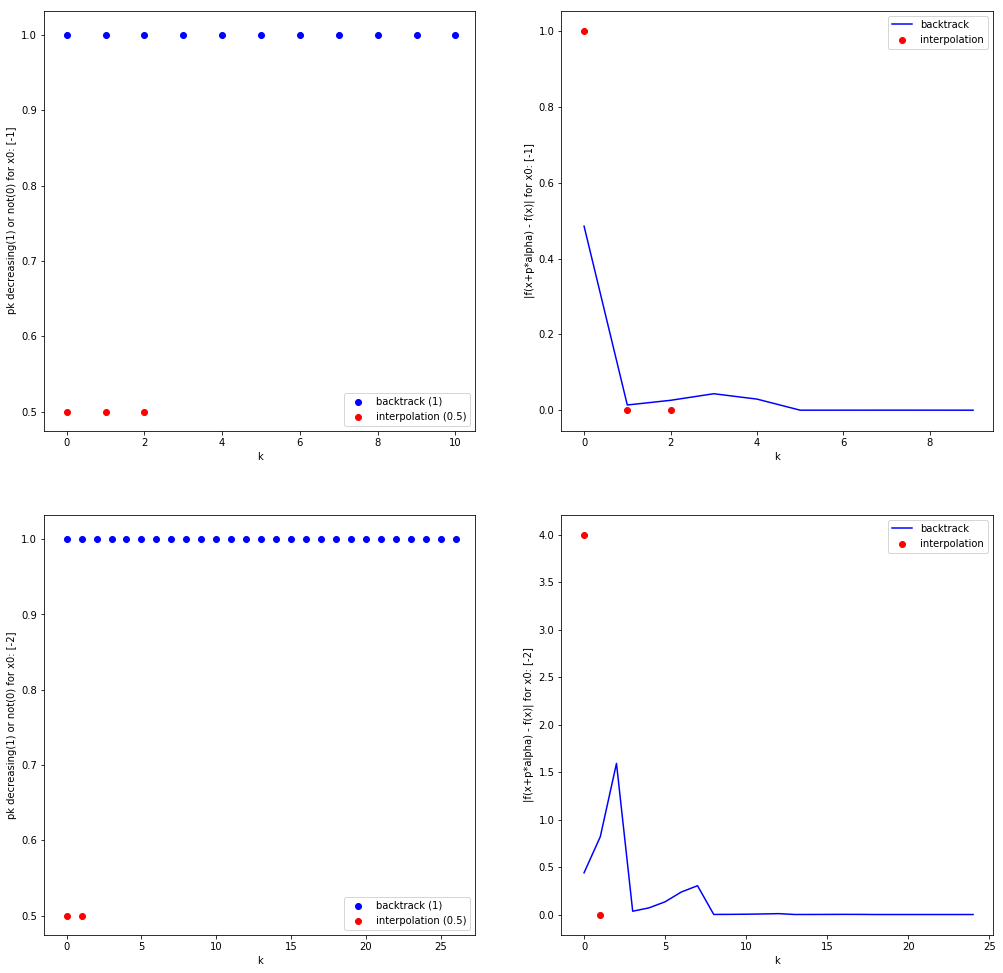

In [70]:
wc1 = .001
wc2 = .0005
gc = .05

progress_data1 = [get_progress_steepest_descent(f2, g2, x2s[i], wc1, .95, 1.1, backtrack_selection=True) for i in range(len(x2s))]
progress_data2 = [get_progress_steepest_descent(f2, g2, x2s[i], wc1, .95, 1.1, decreasing_mul=.5, backtrack_selection=False) for i in range(len(x2s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    ps1 = progress_data1[i][0]
    differences1 = progress_data1[i][1]
    differences1 = differences1[len(differences1)/10:]
    xp1 = [j for j in range(len(ps1))]
    xd1 = [j for j in range(len(differences1))]
    
    ps2 = progress_data2[i][0]
    differences2 = progress_data2[i][1]
    differences2 = differences2[len(differences2)/10:]
    xp2 = [j for j in range(len(ps2))]
    xd2 = [j for j in range(len(differences2))]
    
    plt.subplot(len(x2s), 2, (i+1)*2-1)
    plt.scatter(xp1, ps1, color='blue', label='backtrack (1)')
    plt.scatter(xp2, ps2, color='red', label='interpolation (0.5)')
    plt.xlabel('k')
    plt.ylabel('pk decreasing(1) or not(0) for x0: %s' % x2s[i])
    plt.legend()
    
    plt.subplot(len(x2s), 2, (i+1)*2)
    if len(xd1) < 5:
        plt.scatter(xd1, differences1, color='blue', label='backtrack')
    else:
        plt.plot(xd1, differences1, color='blue', label='backtrack')
    if len(xd2) < 5:
        plt.scatter(xd2, differences2, color='red', label='interpolation')
    else:
        plt.plot(xd2, differences2, color='red', label='interpolation')
    plt.xlabel('k')
    plt.ylabel('|f(x+p*alpha) - f(x)| for x0: %s' % x2s[i])
    plt.legend()


### Quasi-Newton with BFGS hessian approximation

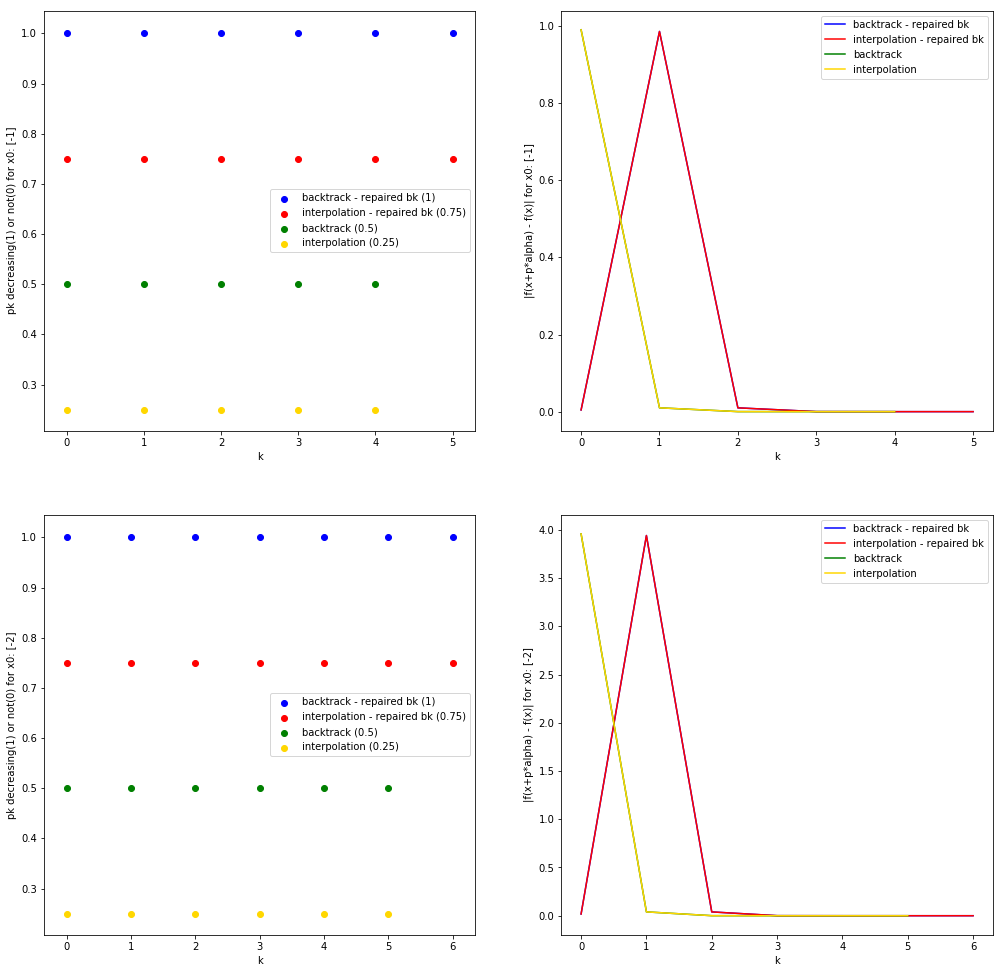

In [71]:
wc1 = .001
wc2 = .0005
gc = .05

progress_data1 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, decreasing_mul=1,
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x2s))]
progress_data2 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, decreasing_mul=.75,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x2s))]
progress_data3 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.5, 
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x2s))]
progress_data4 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.25,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.BFGS) for i in range(len(x2s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    ps1 = progress_data1[i][0]
    differences1 = progress_data1[i][1]
    differences1 = differences1[len(differences1)/10:]
    xp1 = [j for j in range(len(ps1))]
    xd1 = [j for j in range(len(differences1))]
    
    ps2 = progress_data2[i][0]
    differences2 = progress_data2[i][1]
    differences2 = differences2[len(differences2)/10:]
    xp2 = [j for j in range(len(ps2))]
    xd2 = [j for j in range(len(differences2))]
    
    ps3 = progress_data3[i][0]
    differences3 = progress_data3[i][1]
    differences3 = differences3[len(differences3)/10:]
    xp3 = [j for j in range(len(ps3))]
    xd3 = [j for j in range(len(differences3))]
    
    ps4 = progress_data4[i][0]
    differences4 = progress_data4[i][1]
    differences4 = differences4[len(differences4)/10:]
    xp4 = [j for j in range(len(ps4))]
    xd4 = [j for j in range(len(differences4))]
    
    plt.subplot(len(x2s), 2, (i+1)*2-1)
    plt.scatter(xp1, ps1, color='blue', label='backtrack - repaired bk (1)')
    plt.scatter(xp2, ps2, color='red', label='interpolation - repaired bk (0.75)')
    plt.scatter(xp3, ps3, color='green', label='backtrack (0.5)')
    plt.scatter(xp4, ps4, color='gold', label='interpolation (0.25)')
    plt.xlabel('k')
    plt.ylabel('pk decreasing(1) or not(0) for x0: %s' % x2s[i])
    plt.legend()
    
    plt.subplot(len(x2s), 2, (i+1)*2)
    if len(xd1) < 5:
        plt.scatter(xd1, differences1, color='blue', label='backtrack - repaired bk')
    else:
        plt.plot(xd1, differences1, color='blue', label='backtrack - repaired bk')
    if len(xd2) < 5:
        plt.scatter(xd2, differences2, color='red', label='interpolation - repaired bk')
    else:
        plt.plot(xd2, differences2, color='red', label='interpolation - repaired bk')
    if len(xd3) < 5:
        plt.scatter(xd3, differences3, color='green', label='backtrack')
    else:
        plt.plot(xd3, differences3, color='green', label='backtrack')
    if len(xd4) < 5:
        plt.scatter(xd4, differences4, color='gold', label='interpolation')
    else:
        plt.plot(xd4, differences4, color='gold', label='interpolation')
    plt.xlabel('k')
    plt.ylabel('|f(x+p*alpha) - f(x)| for x0: %s' % x2s[i])
    plt.legend()


### Quasi-Newton with exact hessian

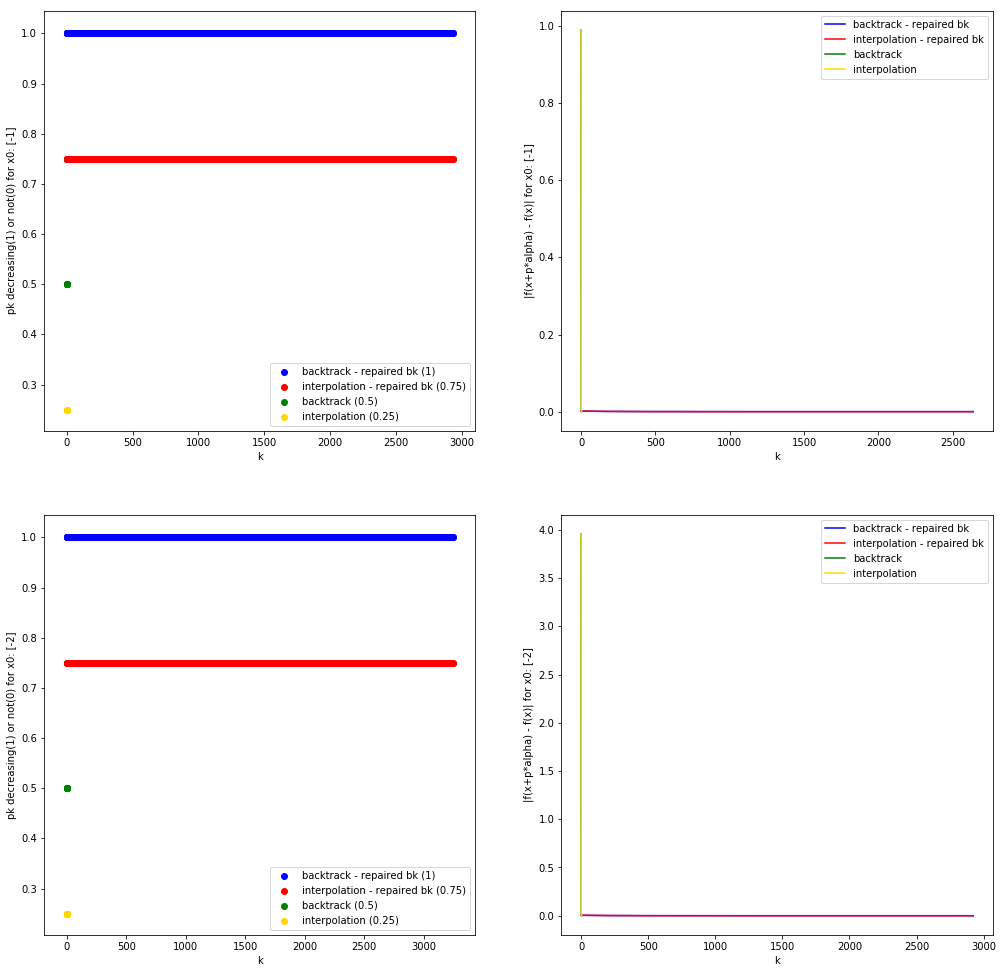

In [73]:
wc1 = .001
wc2 = .0005
gc = .05

progress_data1 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, decreasing_mul=1,
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x2s))]
progress_data2 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, decreasing_mul=.75,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x2s))]
progress_data3 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.5, 
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x2s))]
progress_data4 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.25,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.HESSIAN) for i in range(len(x2s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    ps1 = progress_data1[i][0]
    differences1 = progress_data1[i][1]
    differences1 = differences1[len(differences1)/10:]
    xp1 = [j for j in range(len(ps1))]
    xd1 = [j for j in range(len(differences1))]
    
    ps2 = progress_data2[i][0]
    differences2 = progress_data2[i][1]
    differences2 = differences2[len(differences2)/10:]
    xp2 = [j for j in range(len(ps2))]
    xd2 = [j for j in range(len(differences2))]
    
    ps3 = progress_data3[i][0]
    differences3 = progress_data3[i][1]
    differences3 = differences3[len(differences3)/10:]
    xp3 = [j for j in range(len(ps3))]
    xd3 = [j for j in range(len(differences3))]
    
    ps4 = progress_data4[i][0]
    differences4 = progress_data4[i][1]
    differences4 = differences4[len(differences4)/10:]
    xp4 = [j for j in range(len(ps4))]
    xd4 = [j for j in range(len(differences4))]
    
    plt.subplot(len(x2s), 2, (i+1)*2-1)
    plt.scatter(xp1, ps1, color='blue', label='backtrack - repaired bk (1)')
    plt.scatter(xp2, ps2, color='red', label='interpolation - repaired bk (0.75)')
    plt.scatter(xp3, ps3, color='green', label='backtrack (0.5)')
    plt.scatter(xp4, ps4, color='gold', label='interpolation (0.25)')
    plt.xlabel('k')
    plt.ylabel('pk decreasing(1) or not(0) for x0: %s' % x2s[i])
    plt.legend()
    
    plt.subplot(len(x2s), 2, (i+1)*2)
    if len(xd1) < 5:
        plt.scatter(xd1, differences1, color='blue', label='backtrack - repaired bk')
    else:
        plt.plot(xd1, differences1, color='blue', label='backtrack - repaired bk')
    if len(xd2) < 5:
        plt.scatter(xd2, differences2, color='red', label='interpolation - repaired bk')
    else:
        plt.plot(xd2, differences2, color='red', label='interpolation - repaired bk')
    if len(xd3) < 5:
        plt.scatter(xd3, differences3, color='green', label='backtrack')
    else:
        plt.plot(xd3, differences3, color='green', label='backtrack')
    if len(xd4) < 5:
        plt.scatter(xd4, differences4, color='gold', label='interpolation')
    else:
        plt.plot(xd4, differences4, color='gold', label='interpolation')
    plt.xlabel('k')
    plt.ylabel('|f(x+p*alpha) - f(x)| for x0: %s' % x2s[i])
    plt.legend()


### Quasi-Newton with SR1 hessian approximation

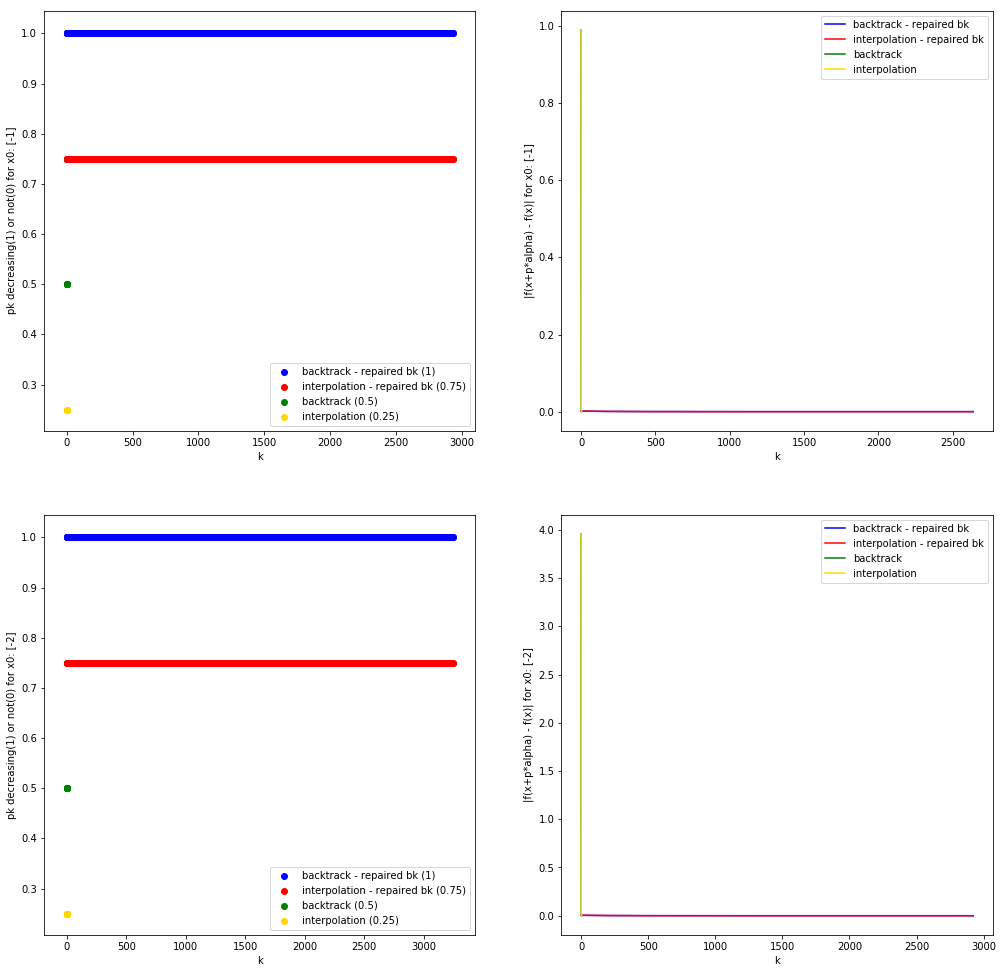

In [75]:
wc1 = .001
wc2 = .0005
gc = .05

progress_data1 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, decreasing_mul=1,
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.SR1) for i in range(len(x2s))]
progress_data2 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, decreasing_mul=.75,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.SR1) for i in range(len(x2s))]
progress_data3 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.5, 
                                            backtrack_selection=True, hessian_method=qn.HessianMethod.SR1) for i in range(len(x2s))]
progress_data4 = [get_progress_quasi_newton(f2, g2, h2, x2s[i], wc1, .95, 1.1, repair_hessian=False, decreasing_mul=.25,
                                            backtrack_selection=False, hessian_method=qn.HessianMethod.SR1) for i in range(len(x2s))]

plt.rcParams['figure.figsize'] = [17, 17]
for i in range(len(x2s)):
    
    ps1 = progress_data1[i][0]
    differences1 = progress_data1[i][1]
    differences1 = differences1[len(differences1)/10:]
    xp1 = [j for j in range(len(ps1))]
    xd1 = [j for j in range(len(differences1))]
    
    ps2 = progress_data2[i][0]
    differences2 = progress_data2[i][1]
    differences2 = differences2[len(differences2)/10:]
    xp2 = [j for j in range(len(ps2))]
    xd2 = [j for j in range(len(differences2))]
    
    ps3 = progress_data3[i][0]
    differences3 = progress_data3[i][1]
    differences3 = differences3[len(differences3)/10:]
    xp3 = [j for j in range(len(ps3))]
    xd3 = [j for j in range(len(differences3))]
    
    ps4 = progress_data4[i][0]
    differences4 = progress_data4[i][1]
    differences4 = differences4[len(differences4)/10:]
    xp4 = [j for j in range(len(ps4))]
    xd4 = [j for j in range(len(differences4))]
    
    plt.subplot(len(x2s), 2, (i+1)*2-1)
    plt.scatter(xp1, ps1, color='blue', label='backtrack - repaired bk (1)')
    plt.scatter(xp2, ps2, color='red', label='interpolation - repaired bk (0.75)')
    plt.scatter(xp3, ps3, color='green', label='backtrack (0.5)')
    plt.scatter(xp4, ps4, color='gold', label='interpolation (0.25)')
    plt.xlabel('k')
    plt.ylabel('pk decreasing(1) or not(0) for x0: %s' % x2s[i])
    plt.legend()
    
    plt.subplot(len(x2s), 2, (i+1)*2)
    if len(xd1) < 5:
        plt.scatter(xd1, differences1, color='blue', label='backtrack - repaired bk')
    else:
        plt.plot(xd1, differences1, color='blue', label='backtrack - repaired bk')
    if len(xd2) < 5:
        plt.scatter(xd2, differences2, color='red', label='interpolation - repaired bk')
    else:
        plt.plot(xd2, differences2, color='red', label='interpolation - repaired bk')
    if len(xd3) < 5:
        plt.scatter(xd3, differences3, color='green', label='backtrack')
    else:
        plt.plot(xd3, differences3, color='green', label='backtrack')
    if len(xd4) < 5:
        plt.scatter(xd4, differences4, color='gold', label='interpolation')
    else:
        plt.plot(xd4, differences4, color='gold', label='interpolation')
    plt.xlabel('k')
    plt.ylabel('|f(x+p*alpha) - f(x)| for x0: %s' % x2s[i])
    plt.legend()


## Todo: Analyze the results